# Dependencies

In [1]:
path = '/Users/maelfabien/filrouge_pole_emploi/Common/'
local_path = '/Users/maelfabien/Desktop/LocalDB/Videos/'

# Initial steps

In [2]:
#Imports
import cv2
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import TensorBoard
from time import time
from time import sleep
from keras.models import model_from_json
from keras.optimizers import SGD
from scipy.ndimage import zoom
import os

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
emotions = {1 : 'Neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}

In [4]:
#Grab folder
folder = local_path + 'Datas/Actor_01/'
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} videos".format(len(onlyfiles)))

Working with 9 videos


# Video facial emotion recognition using Convolution Neural Networks

## Create train set from video

In [12]:
shape_x = 225
shape_y = 135

In [8]:
def detect_face(frame):
    #Modèle cascade classifier
    cascPath = local_path + '/models/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(
                                                  gray,
                                                  scaleFactor=1.1,
                                                  minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE
                                                  )
                                                  
    return gray, detected_faces

In [9]:
#Extraire les features faciales
def extract_face_features(gray, detected_face, offset_coefficients):
    
    #Region dans laquelle la face est détectée
    (x, y, w, h) = detected_face
    #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur

    
    #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
    horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
    vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #gray transforme l'image
    extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
    #Zoom sur la face extraite
    new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
    #cast type float
    new_extracted_face = new_extracted_face.astype(np.float32)
    #scale
    new_extracted_face /= float(new_extracted_face.max())
    #print(new_extracted_face)
    return new_extracted_face

For 1 folder of datas :

In [44]:
#Output in a .npy file
dataset = np.empty((0, shape_x*shape_y + 1))

j=1
i=1
k=1

for vid in onlyfiles :
    if (vid[0:2] != '02') :

        vidcap = cv2.VideoCapture(folder + vid)
        #success,img = vidcap.read()
        success = True
    
        while success :

            success,img = vidcap.read()
            if not success :
                break

            gray, detected_faces = detect_face(img)
        
            for face in detected_faces :
            
                extracted_face = extract_face_features(gray, face, (0.075, 0.05)) #(0.075, 0.05)

                extracted_face = np.append(extracted_face.flatten(), int(vid[6:8]))
                dataset = np.vstack((dataset, extracted_face))

            i = i + 1
        
        print('Video : '+ str(j))  
    
        j = j + 1

np.save(local_path + 'savedmodels/datas', dataset)

/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Video : 1
Video : 2
Video : 3
Video : 4
Video : 5
Video : 6
Video : 7
Video : 8
Video : 9


For the whole repository :

In [17]:
dataset = np.empty((0, shape_x*shape_y + 1))

j=1
i=1
k=1

for i in range(1,25) :
    folder = local_path + 'Datas/Actor_" + str(i) + "/"
    onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    for vid in onlyfiles :
    
        vidcap = cv2.VideoCapture(folder + vid)
        #success,img = vidcap.read()
        success = True
    
        while success :

            success,img = vidcap.read()
            if not success :
                break

            gray, detected_faces = detect_face(img)
        
            for face in detected_faces :
            
                extracted_face = extract_face_features(gray, face, (0.075, 0.05)) #(0.075, 0.05)
                extracted_face = np.append(extracted_face.flatten(), int(vid[6:8]))
                dataset = np.vstack((dataset, extracted_face))
        
        print('Video : '+ str(j))  
        j = j + 1
        
    i = i + 1
    
np.save(local_path + 'savedmodels/datas', dataset)

SyntaxError: EOL while scanning string literal (<ipython-input-17-c699a2be17e1>, line 1)

## Train, Test, Split

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

dataset = np.load("/Users/maelfabien/Desktop/LocalDB/Videos/savedmodels/datas.npy")

np.random.seed(2222)  # for reproducibility

#Load the scaled data, both pixels and labels
X = dataset[:,:-1]
y = dataset[:,-1]

In [8]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)
print(y)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [48]:
X_test.shape

(314, 30375)

In [13]:
#reshape the given pixels into 48 X 48 images
X_train = X_train.reshape(X_train.shape[0] ,shape_x , shape_y,1)
X_test = X_test.reshape(X_test.shape[0] ,shape_x , shape_y,1)

#convert labels to one-hot-encoding
Y_tr_labels = np_utils.to_categorical(y)

## CNN, Tensorboard

<img src = "/Users/maelfabien/filrouge_pole_emploi/Video/Resources/Schema_Emocognizer.png">

In [50]:
#define the model 32 filters in first convolution layer followed by a max pooling and dense layer with dropout (50%)
model = Sequential()

#nb_filter, nb_row, nb_col
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(shape_x,shape_y,1)))
model.add(Activation('relu'))
#maxpool
model.add(MaxPooling2D(pool_size=(2, 2)))
#flatten
model.add(Flatten())
#regular densely-connected NN layer, 128 units = dimension of the output space
model.add(Dense(128,init='lecun_uniform'))
#randomly selected neurons are ignored during training
model.add(Dropout(0.4))
model.add(Activation('relu'))
#another layer
model.add(Dense(8))
model.add(Activation('softmax'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(225, 135,..., padding="valid")`
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="lecun_uniform")`
  if sys.path[0] == '':


In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 223, 133, 32)      320       
_________________________________________________________________
activation_4 (Activation)    (None, 223, 133, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 66, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 234432)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               30007424  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
__________

In [52]:
#training the model with cross sgd and nesterov momentum
sgd = SGD(lr=0.055, decay=1e-6, momentum=0.9, nesterov=True)

In [53]:
#tensorboard --logdir=logs/

In [60]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(X_train,y_train, validation_data=(X_test, y_test), batch_size=128 , nb_epoch=10, callbacks=[tensorboard])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 581 samples, validate on 314 samples
Epoch 1/10
581/581 [==============================] - 15s 26ms/step - loss: 2.0023 - acc: 0.2806 - val_loss: 1.9250 - val_acc: 0.3376
Epoch 2/10
581/581 [==============================] - 12s 20ms/step - loss: 1.8006 - acc: 0.3528 - val_loss: 1.5889 - val_acc: 0.3376
Epoch 3/10
581/581 [==============================] - 12s 21ms/step - loss: 1.8281 - acc: 0.3133 - val_loss: 1.6182 - val_acc: 0.5796
Epoch 4/10
581/581 [==============================] - 13s 22ms/step - loss: 1.5314 - acc: 0.4974 - val_loss: 1.5246 - val_acc: 0.4172
Epoch 5/10
581/581 [==============================] - 13s 22ms/step - loss: 1.5714 - acc: 0.4647 - val_loss: 0.8750 - val_acc: 0.7229
Epoch 6/10
581/581 [==============================] - 13s 23ms/step - loss: 0.8615 - acc: 0.6971 - val_loss: 0.5037 - val_acc: 0.8503
Epoch 7/10
581/581 [==============================] - 12s 21ms/step - loss: 0.9141 - acc: 0.6867 - val_loss: 0.5678 - val_acc: 0.7643
Epoch 8/10
581/5

In [67]:
#save the model weights
import h5py
json_string = model.to_json()
model.save_weights(local_path + 'savedmodels/Model.h5')
open(local_path + 'savedmodels/Model.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

2423

## Make prediction

In [14]:
with open(local_path + 'savedmodels/Model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)

loaded_model.load_weights(local_path + 'savedmodels/Model.h5')
print("Loaded model from disk")

Loaded model from disk


In [15]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 98.73%


In [17]:
pred = loaded_model.predict_classes(X_test)
print(pred)

[1 2 4 1 5 6 6 6 3 5 5 1 2 3 6 0 4 7 0 5 6 2 3 7 4 7 5 7 5 2 4 5 1 3 3 7 5
 3 1 1 5 2 7 1 6 5 5 6 3 0 2 0 6 0 6 7 5 6 3 5 1 2 2 3 3 0 5 2 4 4 6 6 2 0
 0 4 1 1 6 3 6 5 6 4 3 4 3 6 0 3 3 4 7 1 5 6 7 6 6 6 1 4 6 0 4 4 7 7 6 3 0
 3 4 4 2 0 5 6 6 1 4 3 6 5 1 7 1 5 1 1 6 5 2 1 0 0 6 3 7 5 0 0 6 7 0 2 3 5
 5 7 4 4 1 5 5 7 1 5 7 7 6 0 2 6 5 5 2 0 4 6 5 1 1 0 2 0 5 5 5 6 1 1 1 0 5
 4 6 5 5 0 7 3 4 5 3 2 4 0 1 4 6 1 4 1 1 4 1 2 7 2 6 6 2 4 1 5 4 3 2 2 5 3
 2 6 0 3 7 6 6 5 1 4 3 6 3 4 0 0 1 7 6 2 5 1 4 6 2 7 3 1 5 5 1 5 1 1 0 1 6
 5 2 4 6 1 7 2 2 2 2 7 3 1 6 6 0 5 0 3 4 0 5 5 6 2 5 3 5 4 3 0 1 4 1 5 3 5
 4 7 5 7 6 0 5 3 3 6 0 5 2 0 3 5 4 5]


# Video facial emotion recognition extracting facial features

## Extract facial landmarks

In [ ]:
# import the necessary packages
from collections import OrderedDict
import argparse
import dlib
import imutils

facial_features_cordinates = {}

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions
FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 17))
])


def shape_to_numpy_array(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coordinates = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coordinates[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coordinates


def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    # create two copies of the input image -- one for the
    # overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()

    # if the colors list is None, initialize it with a unique
    # color for each facial landmark region
    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                  (168, 100, 168), (158, 163, 32),
                  (163, 38, 32), (180, 42, 220)]

    # loop over the facial landmark regions individually
    for (i, name) in enumerate(FACIAL_LANDMARKS_INDEXES.keys()):
        # grab the (x, y)-coordinates associated with the
        # face landmark
        (j, k) = FACIAL_LANDMARKS_INDEXES[name]
        pts = shape[j:k]
        facial_features_cordinates[name] = pts

        # check if are supposed to draw the jawline
        if name == "Jaw":
            # since the jawline is a non-enclosed facial region,
            # just draw lines between the (x, y)-coordinates
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        # otherwise, compute the convex hull of the facial
        # landmark coordinates points and display it
        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    # apply the transparent overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    # return the output image
    print(facial_features_cordinates)
    return output

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/Users/maelfabien/Desktop/LocalDB/Videos/landmarks/shape_predictor_68_face_landmarks.dat 2')

## Visualize detected faces on an image

In [77]:
from random import randint
import cv2
import sys
import os
      
CASCADE= local_path + 'FaceDetect/Face_cascade.xml'
FACE_CASCADE=cv2.CascadeClassifier(CASCADE)

def detect_faces(image_path):

	image=cv2.imread(image_path)
	image_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

	faces = FACE_CASCADE.detectMultiScale(image_grey,scaleFactor=1.16,minNeighbors=5,minSize=(25,25),flags=0)

	for x,y,w,h in faces:
	    sub_img=image[y-10:y+h+10,x-10:x+w+10]
	    os.chdir("Extracted")
	    cv2.imwrite(str(randint(0,10000))+".jpg",sub_img)
	    os.chdir("../")
	    cv2.rectangle(image,(x,y),(x+w,y+h),(255, 255,0),2)

	cv2.imshow("Faces Found",image)
	if (cv2.waitKey(0) & 0xFF == ord('q')) or (cv2.waitKey(0) & 0xFF == ord('Q')):
		cv2.destroyAllWindows()

In [ ]:
detect_faces('/Users/maelfabien/filrouge_pole_emploi/Common/test_samples/trump.jpg')

## Live output

In [ ]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread('/Users/maelfabien/filrouge_pole_emploi/Common/test_samples/trump.jpg')
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)

    output = visualize_facial_landmarks(image, shape)
    cv2.imshow("Image", output)
    cv2.waitKey(0)

In [ ]:
from __future__ import division
import dlib
import cv2
import numpy as np

def resize(img, width=None, height=None, interpolation=cv2.INTER_AREA):
    global ratio
    w, h = img.shape

    if width is None and height is None:
        return img
    elif width is None:
        ratio = height / h
        width = int(w * ratio)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized
    else:
        ratio = width / w
        height = int(h * ratio)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

camera = cv2.VideoCapture(0)

predictor_path = 'C:\\Users\\nikgens\\Anaconda3\\pkgs\\dlib-19.4-np111py36_200\\info\\recipe\\shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

while True:

    ret, frame = camera.read()
    if ret == False:
        print('Failed to capture frame from camera. Check camera index in cv2.VideoCapture(0) \n')
        break

    frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_resized = resize(frame_grey, width=120)

    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    dets = detector(frame_resized, 1)
    if len(dets) > 0:
        for k, d in enumerate(dets):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy array
            shape = predictor(frame_resized, d)
            shape = shape_to_np(shape)

            # loop over the (x, y)-coordinates for the facial landmarks
            # and draw them on the image
            for (x, y) in shape:
                cv2.circle(frame, (int(x/ratio), int(y/ratio)), 3, (255, 255, 255), -1)
            #cv2.rectangle(frame, (int(d.left()/ratio), int(d.top()/ratio)),(int(d.right()/ratio), int(d.bottom()/ratio)), (0, 255, 0), 1)

    cv2.imshow("image", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        camera.release()
        break

# Audio

# Text

In [7]:
import PyPDF2
pdf_file = open("/Users/maelfabien/Desktop/Stage2019/SPLUNK/Cover_Letter_Maël_Fabien.pdf", 'rb')
read_pdf = PyPDF2.PdfFileReader(pdf_file)
number_of_pages = read_pdf.getNumPages()
page = read_pdf.getPage(0)
page_content = page.extractText()
page_content.encode('utf-8')
page_content = page_content.replace("\n", " ")
print(page_content.encode('utf-8'))

b'Dear Madam, dear Sir,  My name is Ma\xe2\x80\x9al Fabien. I have studied in Lausanne, Switzerland for the past 5 years  and graduated earlier this year from a Master in Actuarial Science. Statistics and  computer science have always been my main interests throughout my studies.  Therefore, I decided to join one of France\xc3\x95s top engineering school, Telecom Paris  Tech, for an  MS in Big Data, a post-degree program focusing on both quantitative  techniques of machine learning / deep learning, and computer science. I am currently  seeking a six months internship position starting summer 2019, in the \xc3\x9eeld of machine  learning.   Parallel to my studies, I have worked for two years as a teaching assistant for Professor  Boris Nikolov in Corporate Finance, and for Professor Nils Soguel in Public Finance. I  had the opportunity to help undergraduate students in problem sets solving and other  course related tasks. These opportunities are offered in Switzerland to students scorin

# Ensemble model

In [34]:
#Grab file
file = path + "/Voice/pyAudioAnalysis/happy.mp4"

In [38]:
#Output in a .npy file

def process_input(file) :

    pred = []

    #clip = mp.VideoFileClip(folder + vid)
    vidcap = cv2.VideoCapture(file)
    #clip = mp.VideoFileClip(folder + vid)
    #clip.audio.write_audiofile("audio.wav")

    #fig, ax = plt.subplots(1,2,1)
    
    # Test dataset path
    #test_path = "audio.wav"

    # Predict
    #idx_label, prob, _ = aT.fileClassification(test_path, model_path, "svm")
    
    #plt.subplot(2,2,1)
    #plt.bar(label_list, prob)

    success = True
    
    while success :

        success,img = vidcap.read()
    
        if not success :
            break

        gray, detected_faces = detect_face(img)
        
        for face in detected_faces :
            #face_img = face.reshape(gray.shape[0] ,shapex , shapey,1)
            extracted_face = extract_face_features(gray, face, (0.075, 0.05)) #(0.075, 0.05)
            extracted_face = extracted_face.reshape(1 ,shape_x , shape_y,1)
            pred.append(int(model.predict_classes(extracted_face)))
            
    global res
    
    #plt.subplot(1,2,2)
    plt.hist(pred)
    plt.savefig('/output/testplot.png')
    return plt.show()

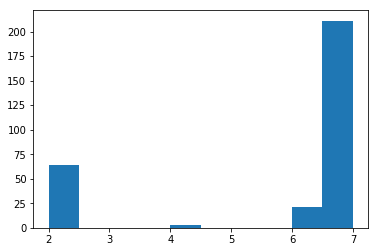

In [39]:
process_input(file)

# Send report when done

In [57]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
 
fromaddr = "mael.fabien@gmail.com"
toaddr = "raphael.lederman@wanadoo.fr"
 
msg = MIMEMultipart()
 
msg['From'] = fromaddr
msg['To'] = toaddr
msg['Subject'] = "Prediction ready"
 
body = "Prediction is now ready, check result in attaxched file"
 
msg.attach(MIMEText(body, 'plain'))
 
filename = "/output/testplot.png"
attachment = open(filename, "rb")
 
part = MIMEBase('application', 'octet-stream')
part.set_payload((attachment).read())
encoders.encode_base64(part)
part.add_header('Content-Disposition', "attachment; filename= %s" % filename)
 
msg.attach(part)
 
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login(fromaddr, "*****")
text = msg.as_string()
server.sendmail(fromaddr, toaddr, text)
server.quit()

(221, b'2.0.0 closing connection k73sm2505912wmd.36 - gsmtp')